In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr

sys.path.append('..')
import project

coords


<IPython.core.display.Javascript object>


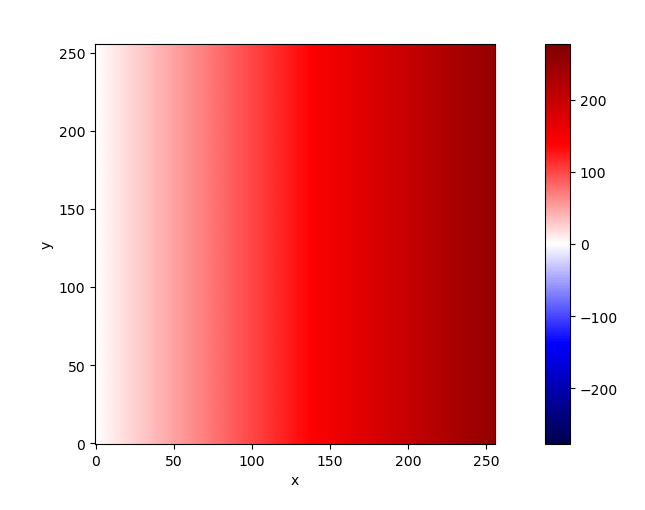

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [3]:
shape = (256, 256, 64)
resolution = (1.0, 1.0, 2.0)

def spatial_coordinates(shape, resolution):
    x = np.arange(shape[0]) * resolution[0]
    y = np.arange(shape[1]) * resolution[1]
    z = np.arange(shape[2]) * resolution[2]
    return np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)

coords = spatial_coordinates(shape, resolution)

project.visual.XArrayViewer(
    project.utils.as_xarray(coords, dims=['x', 'y', 'z', 'component'], name='coords')
)

mask


<IPython.core.display.Javascript object>


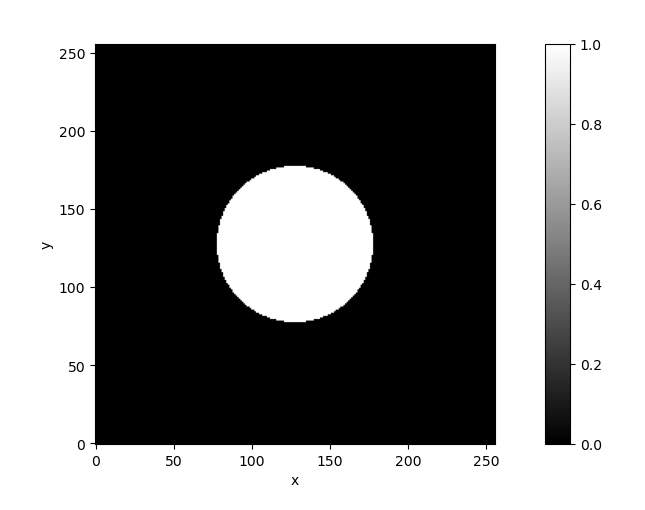

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [4]:
center = coords.mean(axis=(0,1,2), keepdims=True)

def draw_target(coords, center, radius, type_):
    assert type_ in {'disk', 'sphere', 'cube'}
    if type_ == 'disk':
        component = (0,1)
        order = 2
    elif type_ == 'sphere':
        component = (0,1,2)
        order = 2
    elif type_ == 'cube':
        component = (0,1,2)
        order = np.inf
    displacement = (coords - center)[...,component]
    distance = np.linalg.norm(displacement, ord=order, axis=-1)
    return (distance < radius).astype(int)

target = draw_target(coords, center, radius=50, type_='disk')

project.visual.XArrayViewer(
    project.utils.as_xarray(target, dims=['x', 'y', 'z'], name='mask')
)

freqs


<IPython.core.display.Javascript object>


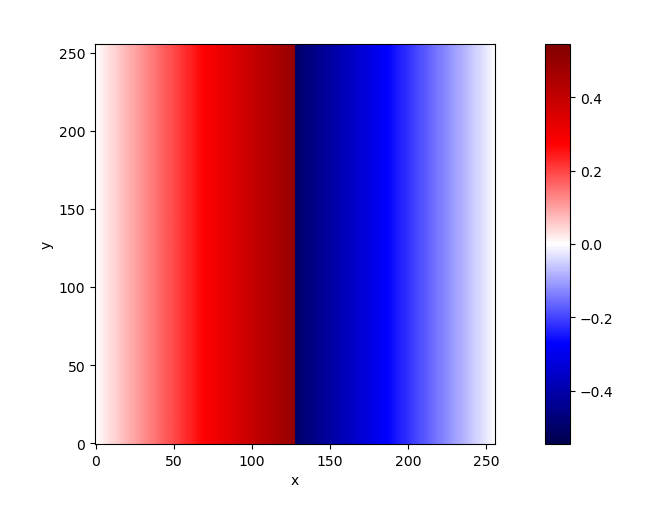

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [5]:
def frequency_coordinates(shape):
    x = np.fft.fftfreq(shape[0])
    y = np.fft.fftfreq(shape[1])
    z = np.fft.fftfreq(shape[2])
    return np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)
    
freqs = frequency_coordinates(shape)

project.visual.XArrayViewer(
    project.utils.as_xarray(freqs, dims=['x', 'y', 'z', 'component'], name='freqs')
)

filter0


<IPython.core.display.Javascript object>


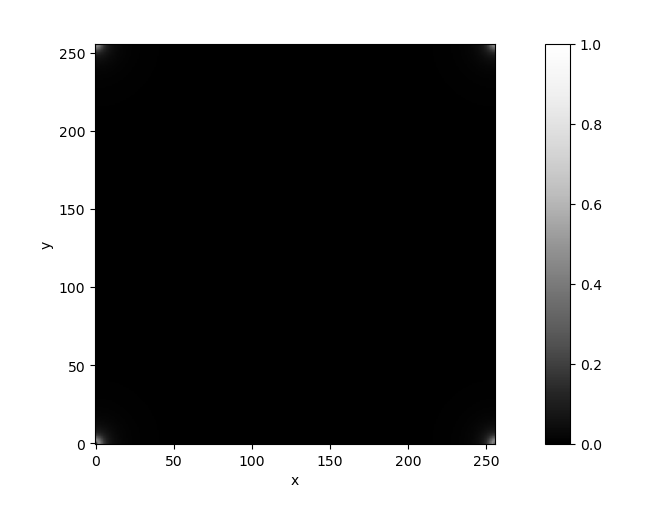

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

filter1


<IPython.core.display.Javascript object>


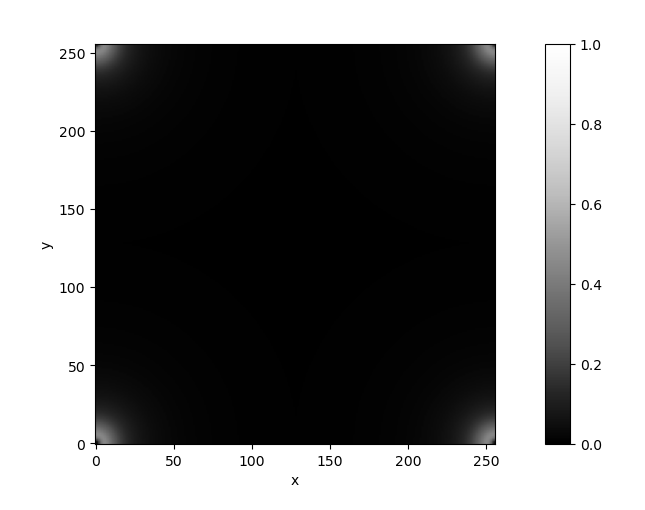

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

filter2


<IPython.core.display.Javascript object>


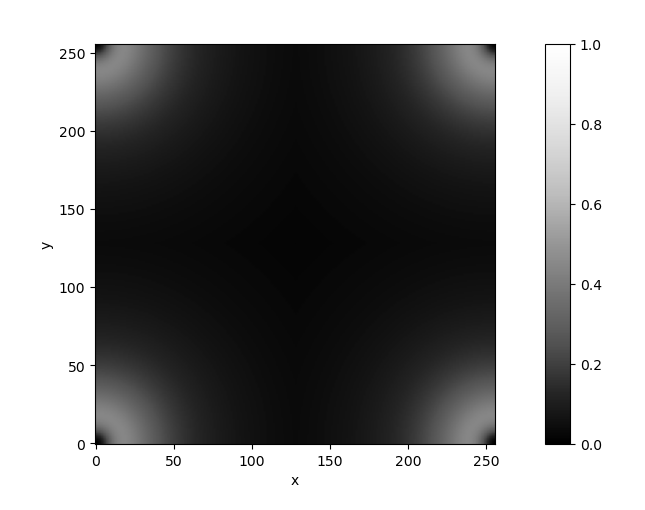

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

filter3


<IPython.core.display.Javascript object>


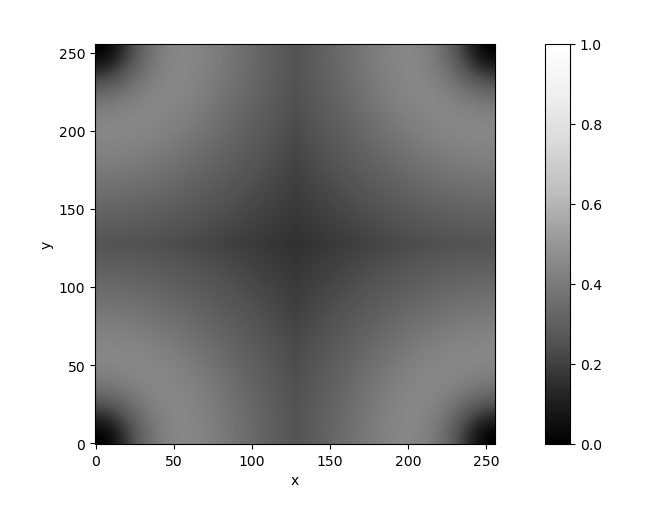

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

filter4


<IPython.core.display.Javascript object>


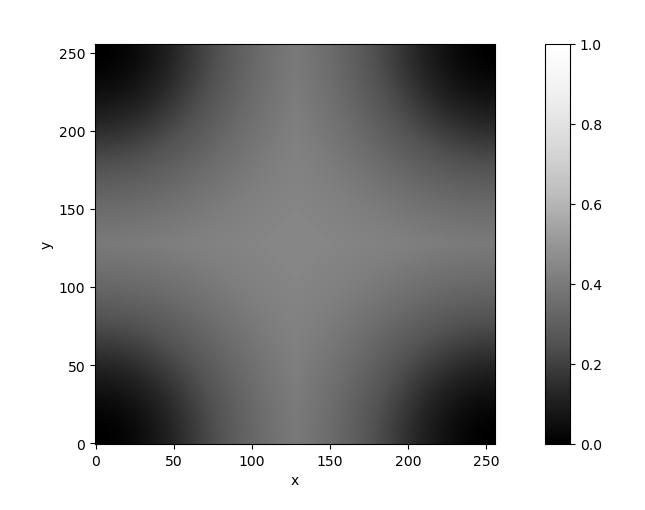

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [6]:
def butterworth_filter(freqs, cutoff, power):
    radius = np.linalg.norm(freqs, axis=-1)
    return 1 / (1 + (radius/cutoff)**power)

def bandpass_filter(freqs, cutoff1, cutoff2, power):
    filter1 = butterworth_filter(freqs, cutoff1, power)
    filter2 = butterworth_filter(freqs, cutoff2, power)
    return (1 - filter1) * filter2

filters = [
    bandpass_filter(freqs, f/2, f, power=2) for f in np.logspace(-2, 0, 5)
]

for i, f in enumerate(filters):
    project.visual.XArrayViewer(
        project.utils.as_xarray(f, dims=['x', 'y', 'z'], name=f'filter{i}'),
        cmap='Greys_r', vmin=0, vmax=1
    )


texture0


<IPython.core.display.Javascript object>


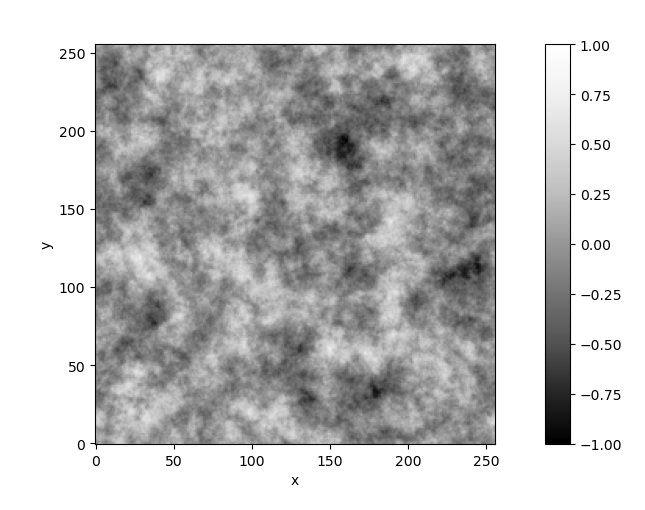

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

texture1


<IPython.core.display.Javascript object>


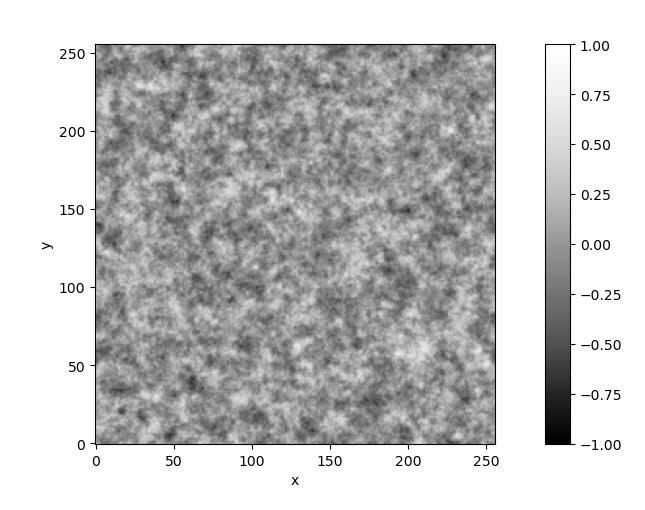

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

texture2


<IPython.core.display.Javascript object>


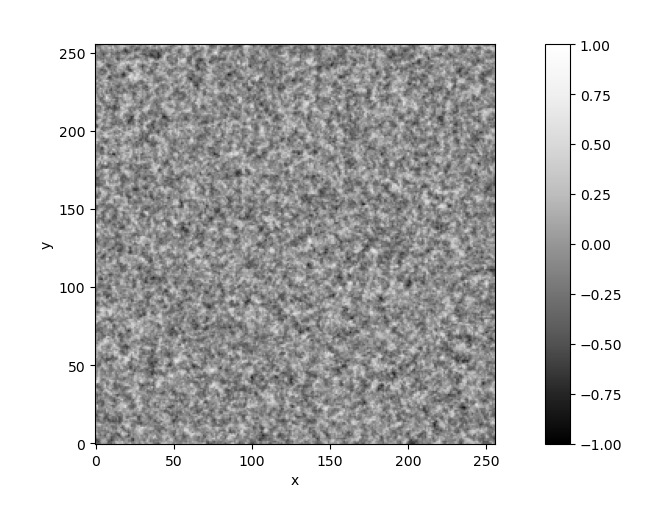

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

texture3


<IPython.core.display.Javascript object>


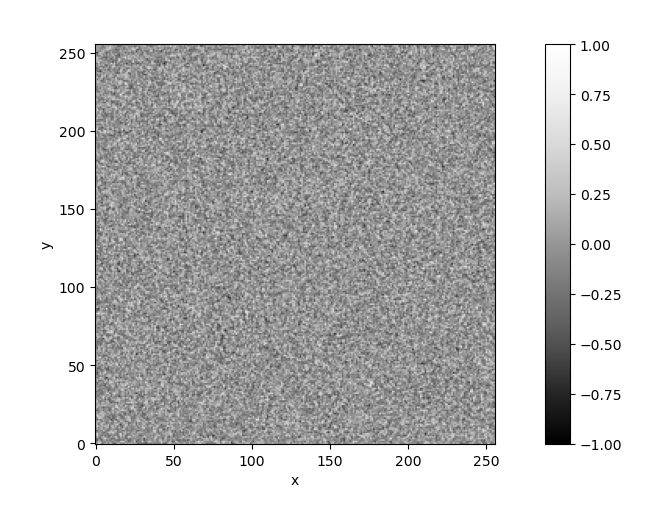

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

texture4


<IPython.core.display.Javascript object>


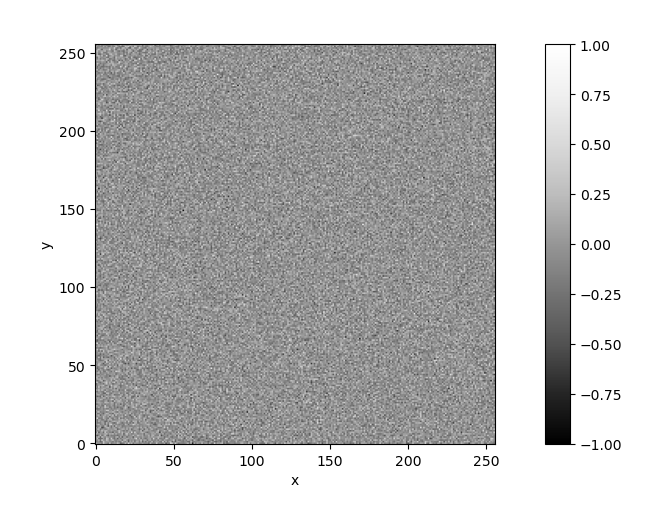

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [7]:
def random_texture(filter_):
    complex_noise = (
        np.random.normal(0, 1, filter_.shape) + 
        np.random.normal(0, 1, filter_.shape) * 1j
    )
    texture = np.fft.ifftn(complex_noise * filter_).real
    texture -= texture.min()
    texture /= texture.max()
    return texture * 2 - 1

textures = [
    random_texture(f) for f in filters
]

for i, t in enumerate(textures):
    project.visual.XArrayViewer(
        project.utils.as_xarray(t, dims=['x', 'y', 'z'], name=f'texture{i}'),
        cmap='Greys_r', vmin=-1, vmax=1,
    )

0.4911668906863085 0.19745140743684464
elast


<IPython.core.display.Javascript object>


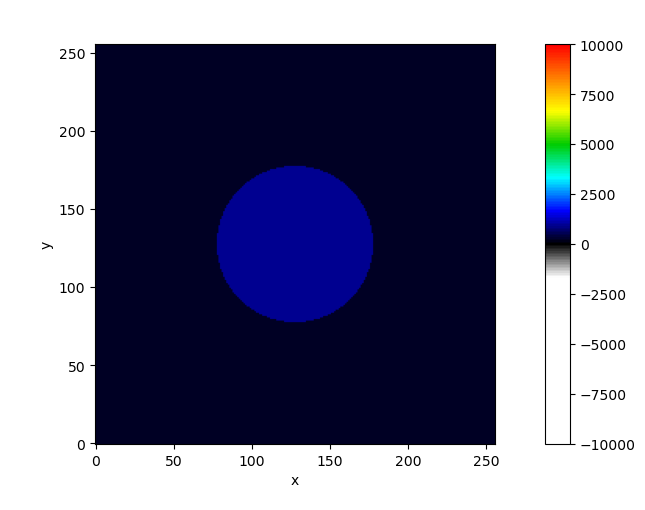

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [8]:
region1 = target
region2 = (1 - target)

# sample latent variables

rand1 = np.random.rand()
rand2 = np.random.rand()
print(rand1, rand2)

# assign stiffness to regions

min_log_kpa = -1
max_log_kpa =  1

log_kpa1 = rand1 * (max_log_kpa - min_log_kpa) + min_log_kpa
log_kpa2 = rand2 * (max_log_kpa - min_log_kpa) + min_log_kpa

mu1 = 10**log_kpa1 * 1000
mu2 = 10**log_kpa2 * 1000
mu = region1 * mu1 + region2 * mu2

project.visual.XArrayViewer(
    project.utils.as_xarray(mu, dims=['x', 'y', 'z'], name='elast'), vmin=-1e4, vmax=1e4
)

-901.2742962815777 607.4043016043231
anat


<IPython.core.display.Javascript object>


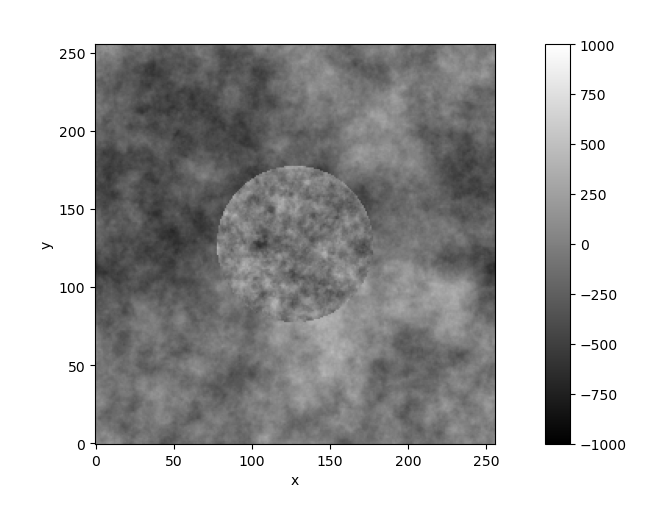

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [9]:
# map latent variables to texture bias and filter parameters

anat_range = 2000
bias_range = 500
bias_midpt = 0
bias_max = bias_midpt + bias_range/2
bias_min = bias_midpt - bias_range/2

bias1 = rand1 * bias_range + bias_min
bias2 = rand2 * bias_range + bias_min

log_cutoff_max =  0
log_cutoff_min = -3

log_cutoff_range = log_cutoff_max - log_cutoff_min

log_cutoff1 = rand1 * log_cutoff_range + log_cutoff_min
log_cutoff2 = rand2 * log_cutoff_range + log_cutoff_min

cutoff1 = 10**log_cutoff1
cutoff2 = 10**log_cutoff2

filter1 = bandpass_filter(freqs, cutoff1/2, cutoff1, power=2)
filter2 = bandpass_filter(freqs, cutoff2/2, cutoff2, power=2)

texture1 = random_texture(filter1)
texture2 = random_texture(filter2)
texture_range = anat_range - bias_range

anat1 = texture1 * texture_range/2 + bias1
anat2 = texture2 * texture_range/2 + bias2
anat = region1 * anat1 + region2 * anat2
print(anat.min(), anat.max())

project.visual.XArrayViewer(
    project.utils.as_xarray(anat, dims=['x', 'y', 'z'], name='anat')
)

displacement


<IPython.core.display.Javascript object>


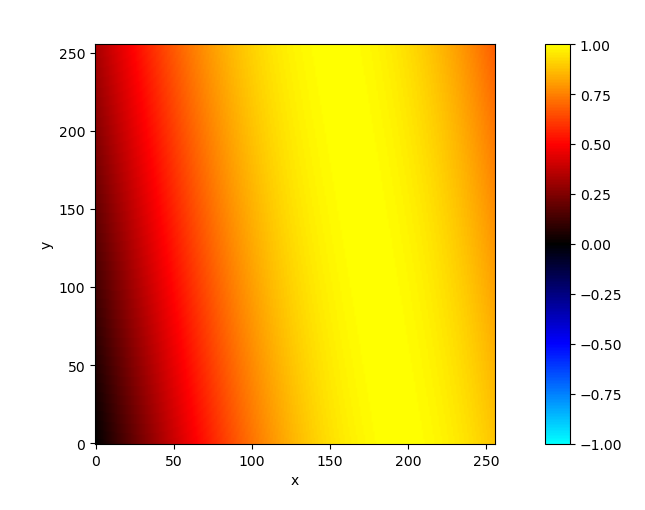

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [10]:
extent = np.max(shape) * np.array(resolution)

phase = np.random.normal(0, 1, (3, 3))

disp = np.sin(2 * np.pi * (coords/extent) @ phase)

project.visual.XArrayViewer(
    project.utils.as_xarray(disp, dims=['x', 'y', 'z', 'c'], name='displacement')
)

In [12]:
import pygalmesh, meshio

mesh = pygalmesh.generate_from_array(
    target.astype(np.uint16) + 1,
    resolution,
    max_cell_circumradius=10.0,
    odt=True
)

mesh = project.meshing.remove_unused_points(mesh)
mesh_file = 'phantom.xdmf'
mesh_cells = [(mesh.cells[1].type, mesh.cells[1].data)]
meshio.write_points_cells(mesh_file, mesh.points, mesh_cells)

In [13]:
mesh = project.data.load_mesh_file(mesh_file)
mesh

Loading phantom.xdmf... 6831


In [14]:
print('\n'*4)

In [52]:
%autoreload
import torch
import nibabel as nib

def generate_phantom(
    random_seed,
    shape=(256, 256, 64),
    resolution=(1.0, 1.0, 2.0),
    target_type='disk',
    target_radius=50,
    min_log_kpa=-1,
    max_log_kpa=1,
    bias_midpoint=0,
    bias_range=500,
    anat_range=2000,
    log_cutoff_min=-3,
    log_cutoff_max=0,
    phase_sigma=1.0,
    mesh_radius=10,
    mesh_file='phantom.xdmf'
):
    print(f'Setting random seed to {random_seed}')
    np.random.seed(random_seed)
    
    # define coordinates over spatial domain
    print('Defining spatial domain...')
    coords = spatial_coordinates(shape, resolution)
    center = coords.mean(axis=(0,1,2), keepdims=True)

    # define spatial regions for target and background
    target = draw_target(coords, center, target_radius, target_type)
    region0 = (target == 0).astype(np.uint16)
    region1 = (target == 1).astype(np.uint16)

    # sample latent variables for each region
    print('Sampling latent variables...')
    latent0 = np.random.rand()
    latent1 = np.random.rand()
    print(latent0, latent1)

    # map latent variables to stiffness values
    print('Generating stiffness map..')
    log_kpa_range = (max_log_kpa - min_log_kpa)
    log_kpa0 = latent0 * log_kpa_range + min_log_kpa
    log_kpa1 = latent1 * log_kpa_range + min_log_kpa

    # assign stiffness to each spatial region
    mu0 = 10**log_kpa0 * 1000
    mu1 = 10**log_kpa1 * 1000
    mu = region0 * mu0 + region1 * mu1

    # map latent variables to anatomical texture and bias
    print('Generating anatomical image...')
    bias_min = bias_midpoint - bias_range/2
    bias0 = latent0 * bias_range + bias_min
    bias1 = latent1 * bias_range + bias_min

    log_cutoff_range = (log_cutoff_max - log_cutoff_min)
    log_cutoff0 = latent0 * log_cutoff_range + log_cutoff_min
    log_cutoff1 = latent1 * log_cutoff_range + log_cutoff_min

    cutoff0 = 10**log_cutoff0
    cutoff1 = 10**log_cutoff1

    freqs = frequency_coordinates(shape)
    filter0 = bandpass_filter(freqs, cutoff0/2, cutoff0, power=2)
    filter1 = bandpass_filter(freqs, cutoff1/2, cutoff1, power=2)

    texture0 = random_texture(filter0)
    texture1 = random_texture(filter1)
    texture_range = (anat_range - bias_range)

    anat0 = texture0 * texture_range/2 + bias0
    anat1 = texture1 * texture_range/2 + bias1
    anat = region0 * anat0 + region1 * anat1
    
    # generate random displacement boundary condition
    print('Generating displacement BC...')
    phase = np.random.normal(0, phase_sigma, (3, 3))
    extent = np.max(shape) * np.array(resolution)
    disp_bc = np.sin(2 * np.pi * (coords/extent) @ phase)

    # generate mesh using pygalmesh
    mask = (target + 1).astype(np.uint16)
    print('Generating mesh...')
    mesh = pygalmesh.generate_from_array(
        mask, resolution,
        max_cell_circumradius=float(mesh_radius),
        odt=True
    )
    mesh = project.meshing.remove_unused_points(mesh)
    
    # save mesh using meshio, then read with fenics
    mesh_cells = [(mesh.cells[1].type, mesh.cells[1].data)]
    meshio.write_points_cells(mesh_file, mesh.points, mesh_cells)
    mesh = project.data.load_mesh_file(mesh_file)
    
    # convert to FEM basis coefficients
    device = 'cpu'
    dtype = torch.float32
    pde = project.pde.LinearElasticPDE(mesh)
    print('Interpolating FEM coefficients...')
    u_dofs = project.interpolation.image_to_dofs(
        torch.as_tensor(disp_bc, dtype=dtype, device=device).permute(3, 0, 1, 2),
        resolution, pde.V,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    mu_dofs = project.interpolation.image_to_dofs(
        torch.as_tensor(mu, dtype=dtype, device=device),
        resolution, pde.S,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    anat_dofs = project.interpolation.image_to_dofs(
        torch.as_tensor(anat, dtype=dtype, device=device),
        resolution, pde.S,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    rho_dofs = (1 + anat_dofs/1000) * 1000
    
    # solve FEM for simulated displacement dofs
    print('Solving FEM model...')
    u_sim_dofs = pde.forward(
        u_dofs.unsqueeze(0),
        mu_dofs.unsqueeze(0),
        rho_dofs.unsqueeze(0),
    )[0]
    
    # convert to displacement image
    print('Converting displacement to image...')
    disp_sim = project.interpolation.dofs_to_image(
        u_sim_dofs, pde.V, disp_bc.shape[:3], resolution
    ).permute(1,2,3,0)
    
    # save images
    affine = np.diag(list(resolution) + [1])
    anat_nifti = nib.nifti1.Nifti1Image(anat, affine)
    mu_nifti = nib.nifti1.Nifti1Image(mu, affine)
    disp_nifti = nib.nifti1.Nifti1Image(disp, affine)
    
    return mu, anat, disp_bc, disp_sim, mask, mesh

mu, anat, disp_bc, disp_sim, mask, mesh = generate_phantom(None)

project.visual.XArrayViewer(project.utils.as_xarray(mu, dims=['x', 'y', 'z'], name='elast'))
project.visual.XArrayViewer(project.utils.as_xarray(anat, dims=['x', 'y', 'z'], name='anat'))
project.visual.XArrayViewer(project.utils.as_xarray(disp_bc, dims=['x', 'y', 'z', 'c'], name='disp'))
project.visual.XArrayViewer(project.utils.as_xarray(disp_sim, dims=['x', 'y', 'z', 'c'], name='disp'))

Setting random seed to None
Defining spatial domain...
Sampling latent variables...
0.21457247893334286 0.34799339604762614
Generating stiffness map..
Generating anatomical image...
Generating displacement BC...
Generating mesh...
Loading phantom.xdmf... 6831
Interpolating FEM coefficients...
Solving FEM model...
Converting displacement to image...



KeyboardInterrupt



In [68]:
import pathlib

class PhantomSet(object):
    
    def __init__(self, data_root, num_phantoms):
        self.data_root = pathlib.Path(data_root)
        self.phantoms = []
        for i in range(num_phantoms):
            phantom = Phantom(data_root, phantom_id=i)
            self.phantoms.append(phantom)
            
    def generate(self, *args, **kwargs):
        self.data_root.mkdir(exist_ok=True)
        for i, phantom in enumerate(self.phantoms):
            phantom.generate(*args, **kwargs)
            
    def get_examples(self, mesh_radius):
        examples = []
        for i, phantom in enumerate(self.phantoms):
            examples.append({
                'name': phantom.phantom_name,
                'anat_file': phantom.anat_file(),
                'disp_file': phantom.disp_file(),
                'mask_file': phantom.mask_file(),
                'mesh_file': phantom.mesh_file(mesh_radius),
                'mesh_radius': mesh_radius
            })
        return examples


class Phantom(object):
    
    def __init__(self, data_root, phantom_id):
        self.data_root = pathlib.Path(data_root)
        self.phantom_id = int(phantom_id)
        
    @property
    def phantom_name(self):
        return f'phantom{self.phantom_id}'
        
    @property
    def phantom_dir(self):
        return self.data_root / self.phantom_name
        
    def anat_file(self):
        return self.phantom_dir / f'{self.phantom_name}_anat.nii.gz'

    def disp_file(self):
        return self.phantom_dir / f'{self.phantom_name}_disp.nii.gz'
    
    def elast_file(self):
        return self.phantom_dir / f'{self.phantom_name}_elast.nii.gz'
    
    def mask_file(self):
        return self.phantom_dir / f'{self.phantom_name}_mask.nii.gz'
    
    def mesh_file(self, mesh_radius):
        return self.phantom_dir / f'{self.phantom_name}_mesh{mesh_radius}.xdmf'
    
    def generate(self, shape, resolution, mesh_radius, **kwargs):
        self.phantom_dir.mkdir(exist_ok=True)
        elast, anat, disp_bc, disp, mask, mesh = generate_phantom(
            random_seed=self.phantom_id,
            shape=shape,
            resolution=resolution,
            mesh_radius=mesh_radius,
            mesh_file=self.mesh_file(mesh_radius),
            **kwargs
        )
        self.elast = project.utils.as_xarray(
            elast, dims=['x', 'y', 'z'], name='elasticity'
        )

        x = np.arange(shape[0]) * resolution[0]
        y = np.arange(shape[1]) * resolution[1]
        z = np.arange(shape[2]) * resolution[2]

        self.elast = xr.DataArray(
            data=elast,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='elasticity'
        )
        self.anat = xr.DataArray(
            data=anat,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='anatomy'
        )
        self.disp = xr.DataArray(
            data=disp,
            dims=['x', 'y', 'z', 'component'],
            coords=dict(x=x, y=y, z=z, component=['x', 'y', 'z']),
            name='displacement'
        )
        self.mask = xr.DataArray(
            data=mask,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='mask'
        )
        affine = np.diag(list(resolution) + [1])
        
        print(f'Saving {self.elast_file()}')
        nib.save(nib.Nifti1Image(self.elast.data, affine), self.elast_file())

        print(f'Saving {self.anat_file()}')
        nib.save(nib.Nifti1Image(self.anat.data, affine), self.anat_file())
              
        print(f'Saving {self.disp_file()}')
        nib.save(nib.Nifti1Image(self.disp.data, affine), self.disp_file())
              
        print(f'Saving {self.mask_file()}')
        nib.save(nib.Nifti1Image(self.mask.data, affine), self.mask_file())  

phantom_set = PhantomSet('../data/phantomset0/', num_phantoms=2)
phantom_set.generate(shape, resolution, mesh_radius=10)

Setting random seed to 0
Defining spatial domain...
Sampling latent variables...
0.5488135039273248 0.7151893663724195
Generating stiffness map..
Generating anatomical image...
Generating displacement BC...
Generating mesh...
Loading ../data/phantomset0/phantom0/phantom0_mesh10.xdmf... 6831
Interpolating FEM coefficients...
Solving FEM model...
Converting displacement to image...
Saving ../data/phantomset0/phantom0/phantom0_elast.nii.gz
Saving ../data/phantomset0/phantom0/phantom0_anat.nii.gz
Saving ../data/phantomset0/phantom0/phantom0_disp.nii.gz
Saving ../data/phantomset0/phantom0/phantom0_mask.nii.gz
Setting random seed to 1
Defining spatial domain...
Sampling latent variables...
0.417022004702574 0.7203244934421581
Generating stiffness map..
Generating anatomical image...
Generating displacement BC...
Generating mesh...
Loading ../data/phantomset0/phantom1/phantom1_mesh10.xdmf... 6831
Interpolating FEM coefficients...
Solving FEM model...
Converting displacement to image...
Saving

In [69]:
examples = phantom_set.get_examples(mesh_radius=10)
examples

[{'name': 'phantom0',
  'anat_file': PosixPath('../data/phantomset0/phantom0/phantom0_anat.nii.gz'),
  'disp_file': PosixPath('../data/phantomset0/phantom0/phantom0_disp.nii.gz'),
  'mask_file': PosixPath('../data/phantomset0/phantom0/phantom0_mask.nii.gz'),
  'mesh_file': PosixPath('../data/phantomset0/phantom0/phantom0_mesh10.xdmf'),
  'mesh_radius': 10},
 {'name': 'phantom1',
  'anat_file': PosixPath('../data/phantomset0/phantom1/phantom1_anat.nii.gz'),
  'disp_file': PosixPath('../data/phantomset0/phantom1/phantom1_disp.nii.gz'),
  'mask_file': PosixPath('../data/phantomset0/phantom1/phantom1_mask.nii.gz'),
  'mesh_file': PosixPath('../data/phantomset0/phantom1/phantom1_mesh10.xdmf'),
  'mesh_radius': 10}]

In [72]:
%autoreload
dataset = project.data.Dataset(examples)
dataset

In [73]:
dataset.load_example(0)

Loading ../data/phantomset0/phantom0/phantom0_anat.nii.gz... (256, 256, 64)
Loading ../data/phantomset0/phantom0/phantom0_disp.nii.gz... (256, 256, 64, 3)
Loading ../data/phantomset0/phantom0/phantom0_mask.nii.gz... (256, 256, 64)
Loading ../data/phantomset0/phantom0/phantom0_mesh10.xdmf... 6831


(tensor([[[[ 319.7645,  164.2467,  111.9459,  ...,   81.0858,  110.7245,
             313.7918],
           [ 228.6680,  156.9334,  249.4349,  ...,  -40.5709,   33.5203,
             202.6682],
           [   8.9935,   11.1213,  152.5271,  ..., -148.7842,  -14.7182,
              91.6657],
           ...,
           [  89.8696,  -15.1302, -128.5238,  ...,  132.2126,  192.7384,
              83.9710],
           [  88.4842,  -42.9064,   58.7024,  ...,   80.3991,  147.1366,
             150.4796],
           [ 252.9675,  128.4270,  125.3280,  ...,   76.8565,  124.6788,
             150.0357]],
 
          [[ 331.0612,  189.7674,  122.0822,  ...,   69.9983,   95.4471,
             293.6716],
           [ 245.9065,  292.6623,  155.1719,  ...,   -8.3156,   25.9967,
             249.9364],
           [ 141.7461,  194.8557,  160.5969,  ..., -113.4012,   19.4865,
             205.8977],
           ...,
           [  16.9960,   62.8767,   68.8585,  ...,   -6.8628,  250.6923,
              52.11